<img src="https://cienciasgeodesicas.ufpr.br/wp-content/uploads/2021/03/cropped-folder-site3.png" alt="Drawing"/>

**Universidade Federal do Paraná**

Programa de Pós-Graduação em Ciências Geodésicas (PPGCG)

---

*PhD Thesis: TOPONYMS IN TOPOGRAPHIC MAPPING: AN INTEGRATED APPROACH USING OPEN AND COLLABORATIVE GEOSPATIAL DATA*

Authors:
 - Darlan Miranda Nunes | [ORCID- 0000-0003-3557-5341](https://orcid.org/0000-0001-5566-7919)
 - Silvana Philippi Camboim | [ORCID- 0000-0003-3557-5341](https://orcid.org/0000-0003-3557-5341)

---

***Article Title: Quantitative Analysis of Collaborative Toponyms in OpenStreetMap: Investigating the Connections with Intrinsic Quality Parameters***

 - DIAGNÓSTICO QUANTITATIVO DOS TOPÔNIMOS COLABORATIVOS NO
OSM E A RELAÇÃO COM OS PARÂMETROS INTRÍNSECOS DE QUALIDADE

**Aims**

- To conduct a quantitative assessment of elements within OpenStreetMap (OSM) that have the 'name' attribute filled for potential categories of the Brazilian Authoritative Topographic Map; and

- To investigate the most significant intrinsic quality parameters that contribute to the reliability of toponyms in OSM.


<img src="../images/flowchart_article01_v2.png" width="600">

### Install the necessary libraries to the analysis

In [ ]:
# In case of using colab, install these necessary libraries
%pip install geopandas matplotlib pysal seaborn mapclassify mgwr -q

### Import the libraries

In [1]:
# Import library and some pre-installed modules
import os
import numpy as np
import json
import folium
import pandas as pd
import geopandas as gpd
import mapclassify
import matplotlib.colors
import seaborn as sns
import statsmodels.api as sm
import warnings
import pyproj
from matplotlib import pyplot as plt
from ipywidgets import widgets, Layout, Button, interact, Dropdown, SelectMultiple, HBox, VBox, Output
from IPython.display import display, clear_output
from folium import plugins, Map, Choropleth, Element, Figure
from folium.features import GeoJson, GeoJsonTooltip
from pysal.explore import esda
from pysal.lib import weights
from shapely.geometry import MultiPolygon, box
from shapely.ops import transform
from jinja2 import Template
from tqdm.notebook import tqdm
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

%matplotlib inline

/Users/darlanmnunes/miniconda3/envs/env-DScPythonGeo/lib/python3.10/site-packages/spaghetti/network.py:42: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)


### Connect to Google Drive

In [ ]:
# In case of using colab, conect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

### Analysis of Collaborative Toponyms in OpenStreetMap

In [2]:
# @title Import the grid with the aggregated data extracted from OSM via the OHSOME API
grid_osm = None

# Function for selecting and loading the GeoJSON file
def select_file(change):
    global grid_osm
    selected_file = change['new']
    
    if selected_file != "Select the GeoJSON file:":
        file_path = os.path.join('../data/', selected_file)
        try:
            with open(file_path, 'r') as file:
                grid_osm = json.load(file)
            print("File selected with success:", selected_file)
            print("File path:", file_path)
        except FileNotFoundError:
            print("File not found:", selected_file)

# Listing available GeoJSON files
file_list = [f for f in os.listdir('../data/') if f.endswith('.geojson')]
options = ["Select the GeoJSON file:"] + file_list

# Dropdown to select the GeoJSON file
dropdown = widgets.Dropdown(options=options)
dropdown.observe(select_file, names='value')

# Display the dropdown
display(dropdown)

Dropdown(options=('Select the GeoJSON file:', 'grade_id77_passare_results.geojson', 'grade_id25_aguaverde_resu…

File selected with success: grade_id77_passare_results.geojson
File path: ../data/grade_id77_passare_results.geojson


In [ ]:
# Preview grid cells
grid_osm

In [3]:
#@title Convert GeoJSON Data to GeoDataFrame
gdf_osm = gpd.GeoDataFrame.from_features(grid_osm['features'])

In [ ]:
# Check the first five records of GeoDataFrame
gdf_osm.head()

In [4]:
# Check the number os grid cell with information retrived of OSM
len(gdf_osm)

220

#### Histogram Analysis

Dropdown(description='Column:', index=8, options=('geometry', 'id', 'POP10', 'leisure_total_count', 'leisure_n…

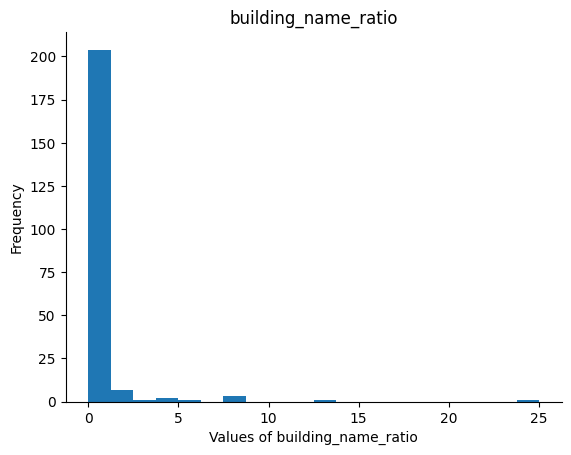

In [5]:
# Preliminary analysis with histograms

import ipywidgets as widgets
from matplotlib import pyplot as plt
from IPython.display import display, clear_output

# Creating a selection widget for columns
dropdown = widgets.Dropdown(
    options = gdf_osm.columns, # list of DataFrame columns
    value = 'building_name_ratio', # default value
    description = 'Column:',
    disabled = False,
)

# Function to plot the histogram
def plot_histogram(column):
    clear_output(wait=True) # clears the previous output
    display(dropdown)  # Show the widget again after clearing the output

    # Plots the histogram for the specified column
    gdf_osm[column].plot(kind='hist', bins=20, title=column)

    # Styling the graphic
    plt.gca().spines[['top', 'right']].set_visible(False)
    plt.xlabel(f'Values of {column}')  # add the  X axis title
    plt.show()

# Linking the plot function to the dropdown value change event
dropdown.observe(lambda change: plot_histogram(change.new), 'value')

# Show the widget
display(dropdown)

# Initial plot
plot_histogram(dropdown.value)

#### Choropleth maps

In [9]:
# Choropleth maps

gdf_osm = gdf_osm.set_crs("EPSG:4674")

# FutureWarning ignore
warnings.simplefilter(action='ignore', category=FutureWarning)

# Function to calculate the centroid of all grid cells in the GeoDataFrame
def calculate_centroid_of_union(gdf):
    union_poly = gdf.geometry.unary_union
    if isinstance(union_poly, MultiPolygon):
        union_poly = MultiPolygon(union_poly).convex_hull
    return [union_poly.centroid.y, union_poly.centroid.x]

# Function to generate the choropleth map using the quantile metohod and folium
def add_choropleth(map_obj, column, method, palette):
    unique_values = len(gdf_osm[column].unique())
    k = min(4, unique_values)

    if method == 'Quantiles':
        classifier = mapclassify.Quantiles(gdf_osm[column], k=k)
    elif method == 'EqualInterval':
        classifier = mapclassify.EqualInterval(gdf_osm[column], k=k)
    elif method == 'NaturalBreaks':
        classifier = mapclassify.NaturalBreaks(gdf_osm[column], k=k)
    else:
        raise ValueError("Classification method not supported")

    colors = [matplotlib.colors.to_hex(matplotlib.colormaps.get_cmap(palette)(i / k)) for i in range(k)]

    gdf_osm['class'] = classifier.yb

    choropleth = folium.Choropleth(
          geo_data=gdf_osm.to_json(),
          data=gdf_osm,
          columns=['id', 'class'],
          key_on='feature.properties.id',
          fill_color=palette,
          fill_opacity=0.5,
          line_opacity=0.4,
          show=False
      ).add_to(map_obj)

    # Add tooltips
    folium.GeoJsonTooltip(fields=['id', column]).add_to(choropleth.geojson)

    return classifier.bins, k  # Returns the intervals to use in the legend

# Function to creating HTML Legend
def create_legend_html(bins, colors, legend_labels, method, column):
    num_intervals = len(bins)
    legend_title = f"{method} classification of {column}"
    legend_html = f'''
    <div style="position: fixed;
    bottom: 50px; left: 50px; width: 200px; height: auto;
    border:2px solid grey; z-index:9999; font-size:14px; padding: 5px; background: rgba(255, 255, 255, 0.8);">
    &nbsp; {legend_title} <br>
    '''
    num_intervals = len(bins)
    for i in range(num_intervals):
        color = matplotlib.colors.rgb2hex(colors[i])
        if i == 0:
            interval_text = f"≤ {bins[i]:.2f}"
        elif i == num_intervals - 1:
            interval_text = f"> {bins[i - 1]:.2f}"
        else:
            interval_text = f"{bins[i - 1]:.2f} - {bins[i]:.2f}"

        legend_html += f'''
        &nbsp; <i style="background: {color}; width: 20px; height: 20px; float: left; margin-right: 4px;"></i>
        <span>{legend_labels[i]}: {interval_text}</span><br clear="all">
        '''
    legend_html += '</div>'
    return legend_html

def get_legend_labels(method, k):
    if method == 'Quantiles':
        return [f'Q{i+1}' for i in range(k)]
    elif method == 'EqualInterval':
        return [f'Interval {i+1}' for i in range(k)]
    elif method == 'NaturalBreaks':
        return [f'Break {i+1}' for i in range(k)]
    else:
        raise ValueError("Classification method not supported")

# Function to update the map with the selected column
def update_map(column, method, palette):
    fig = Figure(width=1080, height=650)
    centroid_coords = calculate_centroid_of_union(gdf_osm)
    
    m = folium.Map(location=centroid_coords, zoom_start=14, control_scale=True)
    m.add_to(fig)

    intervals, k = add_choropleth(m, column, method, palette)
    colors = [matplotlib.colors.to_hex(matplotlib.colormaps.get_cmap(palette)(i / k)) for i in range(k)]
    legend_labels = get_legend_labels(method, k)

    legend_html = create_legend_html(intervals, colors, legend_labels, method, column)
    m.get_root().html.add_child(Element(legend_html))

    title_html = f'''
    <div style="position: fixed;
    top: 10px; left: 50%; transform: translate(-50%, 0); width: auto;
    border:2px solid grey; z-index:9999; font-size:16px; font-weight: bold;
    background: rgba(255, 255, 255, 0.8); text-align: center; padding: 5px;">
    Choropleth map of {column}</div>
    '''
    m.get_root().html.add_child(folium.Element(title_html))

    display(fig)

    # Save the map to an HTML file
    # m.save('../output/map.html')

# Dropdown widget for column selection
column_selector = widgets.Dropdown(
    options=gdf_osm.columns,
    value='building_name_ratio', # default value
    description='Column:',
    layout=Layout(width='30%', height='30px')
)

method_selector = widgets.Dropdown(
    options=['Quantiles', 'EqualInterval', 'NaturalBreaks'],
    value='Quantiles',  # default
    description='Method:',
    layout=Layout(width='30%', height='30px')
)

palette_selector = widgets.Dropdown(
    options=plt.colormaps(),
    value='YlGn',  # default value
    description='Palette:',
    layout=Layout(width='30%', height='30px')
)

# Buttons for generating and clearing the map
generate_button = widgets.Button(description="Generate Map")
clear_button = widgets.Button(description="Clear Output")

# Define event handlers for the buttons
def on_generate_button_clicked(b):
    clear_output(wait=True)
    display_widgets()  # Redisplay widgets to maintain UI state
    update_map(column_selector.value, method_selector.value, palette_selector.value)

def on_clear_button_clicked(b):
    clear_output(wait=True)
    display_widgets()

# Function to display widgets with the appropriate layout
def display_widgets():
    display(VBox([
        column_selector,
        method_selector,
        palette_selector,
        HBox([generate_button, clear_button])
    ]))

# Connect buttons to their event handlers
generate_button.on_click(on_generate_button_clicked)
clear_button.on_click(on_clear_button_clicked)

# Display the Widgets initially
display_widgets()

In [10]:
# Checking the ne column used to calculate the quantiles
print(gdf_osm['building_name_ratio'].describe())

count    220.000000
mean       0.452590
std        2.202964
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       25.000000
Name: building_name_ratio, dtype: float64


#### Spatial Autocorrelation Analysis

##### Global Moran's Index

- The bellow ceel code allows the user to select multiple variables from a GeoDataFrame and then analyze each one for spatial autocorrelation using Moran's I. The results, including the value of Moran's I and its p-value, are printed and visualized in a scatterplot for each selected variable. The selection widget's width is adjusted for better display.


- Statistical test

  - Null hypothesis represents the spatial independence of the data (Spatial distribution of the variable in question is random )
  - Confidence margin of 95% (p value < .05)

In [12]:
import warnings
from pysal.lib import weights
from esda.moran import Moran
from splot.esda import plot_moran

# FutureWarning ignore
warnings.simplefilter(action='ignore', category=FutureWarning)

# Function to perform Moran's I analysis
def analyze_morans_i(selected_vars):
    w = weights.Queen.from_dataframe(gdf_osm, use_index=True)
    w.transform = 'r'

    for var in selected_vars:
        moran = Moran(gdf_osm[var], w)
        print(f"Moran's Index for {var}: {moran.I:.4f}, p-value: {moran.p_sim}")

        # Plot the Moran scatterplot
        plot_moran(moran, zstandard=True, figsize=(10, 4))
        plt.show()

# Button to perform the analysis and clear output
analyze_button = widgets.Button(description="Analyze Moran's I")
clear_output_button = widgets.Button(description="Clear Output")

# Create the selection widget for selecting multiple variables
select_variables = widgets.SelectMultiple(
    options=gdf_osm.columns,
    value=['leisure_name_ratio'],  # default value
    description='Variables:',
    disabled=False,
    layout={'width': '50%', 'height': '200px'}
)

# Function to handle button click event for analyzing Moran's I
def on_analyze_button_clicked(b):
    clear_output(wait=True)
    display_widgets()  # Redisplay widgets to maintain UI state
    analyze_morans_i(select_variables.value)

# Function to handle button click event for clearing the output
def on_clear_output_button_clicked(b):
    clear_output(wait=True)
    display_widgets()

# Function to display widgets with the appropriate layout
def display_widgets():
    display(VBox([
        select_variables,
        HBox([analyze_button, clear_output_button])
    ]))

# Connect the buttons to their respective event handlers
analyze_button.on_click(on_analyze_button_clicked)
clear_output_button.on_click(on_clear_output_button_clicked)

# Display the widgets initially
display_widgets()

##### Hot Spot analysis using the Getis-Ord Gi statistic

In [8]:
gdf_osm = gdf_osm.set_crs("EPSG:4674")

# Function to calculate the centroid of the union of grid cells
def calculate_centroid_of_union(gdf):
    union_poly = gdf.geometry.unary_union
    if isinstance(union_poly, MultiPolygon):
        union_poly = MultiPolygon(union_poly).convex_hull
    return [union_poly.centroid.y, union_poly.centroid.x]

# Function to color points based on Z-score
def color_producer(val):
    if val > 2.0:
        return 'darkred'  # Significant hot-spot
    elif 1.0 < val <= 2.0:
        return 'red'  # Moderate hot-spot
    elif -1.0 <= val <= 1.0:
        return 'green'  # Non-significant
    elif -2.0 <= val < -1.0:
        return 'blue'  # Moderate Cold-spot
    else:
        return 'darkblue'  # Significant Cold-spot

# Function to calculate Getis-Ord Gi*
def calculate_getis_ord_gi(gdf, var_name):
    w = weights.distance.KNN.from_dataframe(gdf, k=8)  # Adjust 'k' as necessary
    w.transform = 'B'
    gi = esda.G_Local(gdf[var_name], w, star=True)  # 'star' parameter considers all neighbors
    gdf[f"Gi_Z_{var_name}"] = gi.Zs  # Adds Getis-Ord Gi* Z-score to the GeoDataFrame
    return gdf

def create_title_html(selected_var):
    title_html = f'''
    <div style="position: fixed;
    top: 10px; left: 50%; transform: translate(-50%, 0); width: auto;
    border:2px solid grey; z-index:9999; font-size:16px; font-weight: bold;
    background: rgba(255, 255, 255, 0.8); text-align: center; padding: 5px;">
    Getis-Ord Gi* Analysis for {selected_var}</div>
    '''
    return title_html

def create_legend_html():
    legend_html = '''
    <div style="position: fixed;
    bottom: 50px; left: 50px; width: 270px; height: auto;
    border:2px solid grey; z-index:9999; font-size:14px;
    background: rgba(255, 255, 255, 0.8);  /* White with 80% opacity */
    ">&nbsp; <b>Legend</b> <br>
    &nbsp; Significant hot-spot (Z > 2.0) &nbsp; <i style="background:darkred;width:10px;height:10px;display:inline-block;"></i><br>
    &nbsp; Moderate hot-spot (1.0 < Z ≤ 2.0) &nbsp; <i style="background:red;width:10px;height:10px;display:inline-block;"></i><br>
    &nbsp; Non-significant (-1.0 ≤ Z ≤ 1.0) &nbsp; <i style="background:green;width:10px;height:10px;display:inline-block;"></i><br>
    &nbsp; Moderate cold-spot (-2.0 ≤ Z < -1.0) &nbsp; <i style="background:blue;width:10px;height:10px;display:inline-block;"></i><br>
    &nbsp; Significant cold-spot (Z < -2.0) &nbsp; <i style="background:darkblue;width:10px;height:10px;display:inline-block;"></i>
    </div>
    '''
    return legend_html

# Function to perform Getis-Ord Gi* analysis and create the map
def analyze_getis_ord_gi(selected_var):
    print("Processing, please wait...")
    gdf_with_gi = calculate_getis_ord_gi(gdf_osm, selected_var)
    centroid_coords = calculate_centroid_of_union(gdf_with_gi)
    fig = Figure(width=1080, height=650)

    m = folium.Map(location=centroid_coords, zoom_start=14, control_scale=True)
    m.add_to(fig)

    # Adding CircleMarkers for each cell's centroid
    for _, row in gdf_with_gi.iterrows():
        centroid = row.geometry.centroid if isinstance(row.geometry, MultiPolygon) else row.geometry
        folium.CircleMarker(
            location=[centroid.y, centroid.x],
            radius=3,
            color=color_producer(row[f"Gi_Z_{selected_var}"]),
            fill=True,
            fill_opacity=1
        ).add_to(m)

    # Function to apply style to cells
    def style_function(feature):
        value = feature['properties'][f"Gi_Z_{selected_var}"]
        return {
            'fillColor': color_producer(value),
            'color': 'gray',
            'weight': 1,
            'fillOpacity': 0.05,
            'lineOpacity': 0.3
        }

    # Add GeoJson to the map
    folium.GeoJson(
        gdf_with_gi,
        style_function=style_function
    ).add_to(m)

    legend_html = create_legend_html()
    title_html = create_title_html(selected_var)
    m.get_root().html.add_child(folium.Element(legend_html))
    m.get_root().html.add_child(folium.Element(title_html))

    #fig = Figure(width=1080, height=650)
    #fig.add_child(m)

    display(fig)

# Create widgets for user interaction
select_variable_widget = widgets.Select(
    options=gdf_osm.columns,
    description='Variable:',
    disabled=False,
    layout={'width': '30%', 'height': '150px'}
)

analyze_button = widgets.Button(description="Analyze and Show Map")
clear_output_button = widgets.Button(description="Clear Output")

# Layout for displaying widgets
box_layout = VBox([select_variable_widget,
                   HBox([analyze_button, clear_output_button])])
display(box_layout)

def on_analyze_button_clicked(b):
    clear_output(wait=True)
    display(box_layout)
    analyze_getis_ord_gi(select_variable_widget.value)

def on_clear_output_button_clicked(b):
    clear_output(wait=True)
    display(box_layout)

analyze_button.on_click(on_analyze_button_clicked)
clear_output_button.on_click(on_clear_output_button_clicked)



##### Geographically Weighted Regression (GWR)

In [13]:
# @title Reproject the GeoDataFrame to apply GWR
# Function to calculate the centroid of a GeoDataFrame

def get_utm_zone_crs(gdf):
    bounds = gdf.total_bounds
    bbox = box(bounds[0], bounds[1], bounds[2], bounds[3])
    centroid = bbox.centroid
    
    # Determine the UTM zone from the centroid's longitude
    utm_zone = int((centroid.x + 180) / 6) + 1
    hemisphere = 'north' if centroid.y > 0 else 'south'

    # Create a UTM CRS based on the centroid location
    utm_crs = pyproj.CRS(f"+proj=utm +zone={utm_zone} +{hemisphere} +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
    
    return utm_crs

# Set the initial CRS if necessary
gdf_osm = gdf_osm.set_crs("EPSG:4674")

# Obtain the appropriate UTM CRS
utm_crs = get_utm_zone_crs(gdf_osm)

# Project the GeoDataFrame to the detected UTM CRS
gdf_osm_projected = gdf_osm.to_crs(utm_crs.to_string())

gdf_osm_projected.crs

<Projected CRS: +proj=utm +zone=24 +south +ellps=WGS84 +datum=WGS8 ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 24S
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
# @title Applying VIF (Variance Inflation Factor) to identify multicollinearity
# between independent variables in regression models

from statsmodels.stats.outliers_influence import variance_inflation_factor

select_x_variables_widget = SelectMultiple(
    options=[col for col in gdf_osm_projected.columns if col != 'geometry'],
    description='Independent Variables:',
    disabled=False,
    layout=Layout(width='40%', height='200px')
)

vif_button = Button(description="Calculate VIF")
correlation_button = Button(description="Show Correlation Matrix")
clear_button = Button(description="Clear Results")

# Layout to display the widgets
box_layout = VBox([select_x_variables_widget,
                   HBox([vif_button, correlation_button, clear_button])])

# Display the box_layout initially
display(box_layout)


# Function to calculate VIF and display the results
def calculate_vif(b):
    clear_output(wait=True)
    display(box_layout)
    selected_vars = list(select_x_variables_widget.value)

    if len(selected_vars) < 2:
        print("Please select at least two variables to calculate VIF.")
        return

    # Prepare the data for VIF calculation
    variables = gdf_osm_projected[selected_vars]
    vif_data = pd.DataFrame({
        "feature": variables.columns,
        "VIF": [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
    })
            
    # Display the VIF data
    print(vif_data)

# Fucntion to display the correlation matrix
def show_correlation_matrix(b):
    clear_output(wait=True)
    display(box_layout)
    selected_vars = list(select_x_variables_widget.value)
    if len(selected_vars) < 2:
            print("Please select at least two variables to view the correlation matrix.")
            return
            
    variables = gdf_osm_projected[selected_vars]
    corr_matrix = variables.corr()
    plt.figure(figsize=(8,6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Matrix')
    plt.show()

# Clear button click function
def on_clear_button_clicked(b):
    clear_output(wait=True)
    display(box_layout)

# Event bindings
vif_button.on_click(calculate_vif)
correlation_button.on_click(show_correlation_matrix)
clear_button.on_click(on_clear_button_clicked)

In [16]:
#@title Checking the explained variance

features = [col for col in gdf_osm_projected.columns if col != 'geometry' and col not in ['leisure_name_ratio', 'building_name_ratio', 'amenity_name_ratio']]
select_features_widget = SelectMultiple(
    options=features,
    value=[features[0]],
    description='Variables:',
    disabled=False,
    layout=Layout(width='50%', height='120px')
)

plot_button = Button(description="Plot Explained Variance")
clear_button = Button(description="Clear Results")

# Layout setup
box_layout = VBox([select_features_widget,
                   HBox([plot_button, clear_button])
                   ])
display(box_layout)

# Function to plot explained variance
def plot_variance(b):
    clear_output(wait=True)
    display(box_layout)
    selected_features = list(select_features_widget.value)
        
    # Standardizing the selected features
    x = gdf_osm_projected[selected_features]
    x_scaled = StandardScaler().fit_transform(x)
        
     # Applying PCA and capturing the explained variance
    pca = PCA()
    pca.fit(x_scaled)
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)
        
    # Plotting
    plt.figure(figsize=(10, 5))
    plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, align='center', label='Individual explained variance')
    plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', label='Cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal component index')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

# Function to clear results
def clear_results(b):
    clear_output(wait=True)
    display(box_layout)

# Binding the buttons to their respective functions
plot_button.on_click(plot_variance)
clear_button.on_click(clear_results)

In [30]:
# @title Perform Geographically Weighted Regression (GWR) wirh PCA

# Define the widgets
select_y_variable_widget = Dropdown(
    options=[col for col in gdf_osm_projected.columns if col != 'geometry'],
    description='Dependent Variable:',
    disabled=False
    )

select_x_variables_widget = SelectMultiple(
    options=[col for col in gdf_osm_projected.columns if col != 'geometry'],
    description='Independent Variables:',
    disabled=False,
    layout=Layout(width='50%', min_width='300px', height='200px')
)

analyze_button = Button(description="Perform GWR with PCA",layout=Layout(width='auto', min_width='200px'))
clear_button = Button(description="Clear Results", layout=Layout(width='auto', min_width='120px'))

# Layout to which the widgets are added to display
box_layout = VBox([
    select_y_variable_widget,
    select_x_variables_widget,
    HBox([analyze_button, clear_button], layout=Layout(margin='10px 0'))],
    layout=Layout(margin='0 0 10px 0'))

display(box_layout)

# Analyze button click function
def on_analyze_button_clicked(b):
    clear_output()
    display(box_layout)
    print("Processing GWR with PCA, please wait...")
    selected_y_var = select_y_variable_widget.value
    selected_x_vars = list(select_x_variables_widget.value)
        
    # Standardize the selected features
    features = gdf_osm_projected[selected_x_vars]
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
        
    # Perform PCA
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(features_scaled)
    principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
    principal_df['DependentVar'] = gdf_osm_projected[selected_y_var]
        
    #  Preparing geographic coordinates and performing GWR
    coords = np.array(list(zip(gdf_osm_projected.geometry.centroid.x, gdf_osm_projected.geometry.centroid.y)))
    y = principal_df['DependentVar'].values.reshape((-1, 1))
    X = principal_df[['PC1', 'PC2']].values
        
    # Perform GWR
    gwr_selector = Sel_BW(coords, y, X, kernel='bisquare', fixed=False)
    bw = gwr_selector.search()
    gwr_model = GWR(coords, y, X, bw).fit()
        
    # Store and display local R²
    gdf_osm_projected['Local_R2'] = gwr_model.localR2
    plt.figure(figsize=(10, 5))
    plt.scatter(coords[:, 0], coords[:, 1], c=gwr_model.localR2, cmap='Reds')
    plt.colorbar(label='Local R²')
    plt.title(f'GWR Results using {", ".join(["PC1", "PC2"])} for {selected_y_var}')
    plt.show()

# Clear button click function
def on_clear_button_clicked(b):
    clear_output()
    display(box_layout)

# Bind the buttons to their functions
analyze_button.on_click(on_analyze_button_clicked)
clear_button.on_click(on_clear_button_clicked)

#### Multiple Linear Regression Analysis

In [ ]:
# Convert GeoDataFrame to DataFrame by removing the geometry column
gdf_osm_copy = gdf_osm.copy()
df_osm = gdf_osm_copy.drop(columns=['geometry'])

In [ ]:
# Verify the first five records
df_osm.head()

In [ ]:
# Check the data types
df_osm.dtypes

In [ ]:
# Dynamic selection of the dependent variable and the independent variables
# Dependent variables
dependent_var_widget = Dropdown(options=[col for col in df_osm.columns if col != 'id'],
                                description='Dependent Var:')

# Independent variables
independent_vars_widget = SelectMultiple(
    options=[col for col in df_osm.columns if col != 'id'],
    description='Independent Vars:',
    layout={'width': '90%', 'height': '200px'})

# Global Dictionary to store all regression summaries
regression_summaries = {}

# Global dictionary for storing R² values
r2_values = {}

# Function to run the regression
def run_regression(button):
    global regression_summaries, r2_values
    dependent_var = dependent_var_widget.value
    independent_vars = list(independent_vars_widget.value)
    X = df_osm[independent_vars]
    y = df_osm[dependent_var]
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    regression_summary = model.summary().as_text()

    # Print the summary for the current run
    print(regression_summary)

    # Store the summary using the model name as the key
    model_name = f"{dependent_var} ~ {' + '.join(independent_vars)}"
    regression_summaries[model_name] = regression_summary

    # Store R² Adjusted values
    r2_values[model_name] = model.rsquared_adj

# Function to clear the outputs
def clear_outputs(button):
    clear_output()
    display_widgets()

# Function to save all regression results
def save_regression_results(button):
    save_path = '/content/drive/MyDrive/UFPR_PPGCG_DSc/DSc_Dev/02-saidas/02_testes_feicoes_agregadasGrade/agua_verde/v2/regression_summaries.txt'
    if regression_summaries:
        with open(save_path, "w") as file:
            for model, summary in regression_summaries.items():
                file.write(f"Model: {model}\n")
                file.write(f"{summary}\n\n")
        print("All results saved successfully.")
    else:
        print("No results to save.")

# Function to Generate the Bar Chart for Adjusted R² Values
def plot_r2_bar_chart():
    # Convert the dictionary of R² values into a DataFrame for visualization
    df_r2 = pd.DataFrame(list(r2_values.items()), columns=['Model', 'Adjusted R2'])

    # Sort the models by 'Adjusted R2' values for better visualization
    df_r2_sorted = df_r2.sort_values(by='Adjusted R2', ascending=True)

    # Create the bar chart with bars closer together
    fig, ax = plt.subplots(figsize=(10, 8))
    bars = sns.barplot(x='Adjusted R2', y='Model', data=df_r2_sorted, palette='viridis', dodge=False)

    # Add labels and title for the chart
    ax.set_xlabel('Adjusted R²')
    ax.set_ylabel('Model')
    ax.set_title('Adjusted R² Values for Different Regression Models')

    # Add the values on the bars
    for bar in bars.patches:
        ax.text(
            bar.get_width(),  # get the horizontal end point of the bar
            bar.get_y() + bar.get_height() / 2,  # get the y position of the bar
            f'{bar.get_width():.2f}',  # the value we want to add as text
            va='center',  # vertical alignment
            ha='left',  # horizontal alignment
            color='black',  # text color
            fontweight='light'  # font weight
        )

    # Display the chart
    plt.tight_layout()
    plt.show()

# Function to Buttons actions
def button_actions(b):
    if b.description == 'Run Regression':
        run_regression(b)
    elif b.description == 'Clear Outputs':
        clear_outputs(b)
    elif b.description == 'Save Results':
        save_regression_results(b)
    elif b.description == 'Generate R² bar chart':
        plot_r2_bar_chart()

# Create Buttons to run the analysis
run_button = Button(description='Run Regression')
heatmap_button = Button(description='Generate R² bar chart')
save_button = Button(description="Save Results")
clear_button = Button(description="Clear Outputs")

# Assign the button_actions function as the on_click event handler for all buttons
for button in [run_button, heatmap_button, save_button, clear_button]:
    button.on_click(button_actions)

# Organize the widgets
variable_selection_box = VBox([dependent_var_widget, independent_vars_widget])
buttons_box = VBox([run_button, heatmap_button, save_button, clear_button])

# Function to display the widgets
def display_widgets():
    hbox = HBox([variable_selection_box, buttons_box])
    display(hbox)

# Display the Widgets and the Buttons
display_widgets()